In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd 

NUMCLASSES = 1000
RANGEMULT = 2
UNCERTAINITY = 0.0015

dev = (NUMCLASSES/RANGEMULT)*UNCERTAINITY
vec = np.linspace(0, NUMCLASSES, NUMCLASSES, endpoint=False)
def uncertainify(tc):
  return stats.norm.pdf(vec, tc, dev)
#vec = stats.norm.pdf(vec, 500, 1)
target_uncertain_vector = np.array(list(map(uncertainify, [500, 200])))
print(target_uncertain_vector[0])
plt.figure(figsize=(12,5))
plt.plot(target_uncertain_vector[0])
plt.show()


Parquet columns: Index(['Branches', 'Country', 'Month', 'Unit', 'DATA'], dtype='object')

Exports sample (Sweden, 00 Whole fish, fresh, chilled or on ice):
Unit    Country                                 Branches       date  \
1310640  Sweden  00 Whole fish, fresh, chilled or on ice 2015-01-01   
1310641  Sweden  00 Whole fish, fresh, chilled or on ice 2015-02-01   
1310642  Sweden  00 Whole fish, fresh, chilled or on ice 2015-03-01   
1310643  Sweden  00 Whole fish, fresh, chilled or on ice 2015-04-01   
1310644  Sweden  00 Whole fish, fresh, chilled or on ice 2015-05-01   

Unit     fob_value   tonnes  
1310640    24.5692   61.541  
1310641    23.7582   61.397  
1310642    48.4907  125.518  
1310643    22.6574   60.240  
1310644    46.9166  124.095  

Merged series head (fob, tonnes, cpi, fx):
        date  fob_value   tonnes  cpi_index      usd_fx
0 2015-01-01    24.5692   61.541      419.3  131.568095
1 2015-02-01    23.7582   61.397      422.1  132.026500
2 2015-03-01    48.4907  

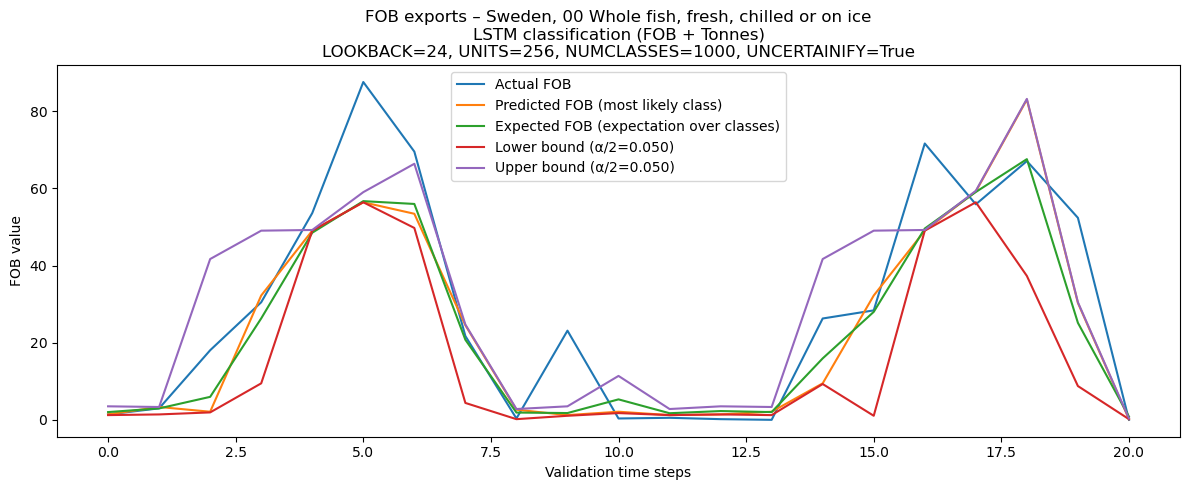

In [60]:
# Final LSTM classification model for FOB using FOB + Tonnes as features

import pandas as pd 
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


# ------------ FINAL HYPERPARAMETERS -------------
LOOKBACK      = 24
NUMCLASSES    = 1000
RANGEMULT     = 2
UNCERTAINITY  = 0.001
UNCERTAINIFY  = True  

EPOCHS        = 100
BATCH_SIZE    = 1
LEARNING_RATE = 0.001
ALPHA         = 0.1

PARQUET_FILE  = "Exports-by-branches-of-processing-and-countries-2015-2025.parquet"
CPI_FILE      = "Inflation-Consumer price index.csv"
FX_FILE       = "Exchange-rates_2015-2025.csv"

TARGET_COUNTRY = "Sweden"
TARGET_BRANCH  = "00 Whole fish, fresh, chilled or on ice"

np.random.seed(42)
tf.random.set_seed(42)


# -------------------------
# Sequence maker
# -------------------------
def make_sequences(X, y, y_class, lookback):
    Xs, ys, ycs = [], [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
        ycs.append(y_class[i+lookback])
    return np.array(Xs), np.array(ys), np.array(ycs)


# ------------------------------------------------------
# WAPE
# ------------------------------------------------------
def calculate_wape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denom = np.sum(np.abs(y_true))
    if denom == 0:
        return 0.0
    return np.sum(np.abs(y_true - y_pred)) / denom * 100.0


# ---------------- DATA LOADING ----------------
def load_exports():
    df = pd.read_parquet(PARQUET_FILE)
    print("Parquet columns:", df.columns)

    # Clean
    df["Country"] = (
        df["Country"].astype(str)
        .str.replace("\xa0", " ", regex=False)
        .str.strip()
    )
    df["Branches"] = df["Branches"].astype(str).str.strip()

    df["date"] = pd.to_datetime(
        df["Month"].astype(str).str.replace("M", "-") + "-01",
        errors="coerce"
    )
    df = df.dropna(subset=["date"])

    # Keep only Fob value + Tonnes
    df = df[df["Unit"].isin(["Fob value", "Tonnes"])].copy()
    df["DATA"] = pd.to_numeric(df["DATA"], errors="coerce")
    df = df.dropna(subset=["DATA"])

    # Pivot to columns
    df_piv = df.pivot_table(
        index=["Country", "Branches", "date"],
        columns="Unit",
        values="DATA",
        aggfunc="sum"
    ).reset_index()

    df_piv = df_piv.rename(columns={"Fob value": "fob_value", "Tonnes": "tonnes"})
    df_piv["fob_value"] = df_piv["fob_value"].fillna(0.0)
    df_piv["tonnes"]    = df_piv["tonnes"].fillna(0.0)

    # Filter target series
    mask = (
        (df_piv["Country"] == TARGET_COUNTRY) &
        (df_piv["Branches"] == TARGET_BRANCH)
    )
    series = df_piv[mask].sort_values("date")

    if series.empty:
        raise ValueError(f"No data for {TARGET_COUNTRY} - {TARGET_BRANCH}")

    print(f"\nExports sample ({TARGET_COUNTRY}, {TARGET_BRANCH}):")
    print(series.head())

    return series[["date", "fob_value", "tonnes"]].reset_index(drop=True)


def load_cpi():
    cpi = pd.read_csv(CPI_FILE)
    cpi["date"] = pd.to_datetime(
        cpi["Month"].astype(str).str.replace("M", "-") + "-01",
        errors="coerce"
    )
    cpi["cpi_index"] = pd.to_numeric(
        cpi["Consumer price index Index"], errors="coerce"
    )
    cpi = cpi.dropna(subset=["date", "cpi_index"])
    return cpi[["date", "cpi_index"]].sort_values("date").reset_index(drop=True)


def load_fx():
    fx = pd.read_csv(FX_FILE, sep=";", engine="python")
    date_col = fx.columns[0]
    fx[date_col] = pd.to_datetime(fx[date_col], errors="coerce", dayfirst=True)

    usd_cols = [c for c in fx.columns if "Bandaríkjadalur" in c and "miðgengi" in c]
    if not usd_cols:
        raise ValueError("USD mid column not found in FX file.")
    usd_col = usd_cols[0]

    fx["usd_fx"] = (
        fx[usd_col]
        .astype(str)
        .str.replace(".", "", regex=False)
        .str.replace(",", ".", regex=False)
    )
    fx["usd_fx"] = pd.to_numeric(fx["usd_fx"], errors="coerce")

    fx = fx.dropna(subset=[date_col, "usd_fx"])
    fx["year_month"] = fx[date_col].dt.to_period("M")
    fx_monthly = fx.groupby("year_month", as_index=False)["usd_fx"].mean()
    fx_monthly["date"] = fx_monthly["year_month"].dt.to_timestamp()
    return fx_monthly[["date", "usd_fx"]].sort_values("date").reset_index(drop=True)


def load_merged_series():
    exp_df = load_exports()
    cpi_df = load_cpi()
    fx_df  = load_fx()

    merged = (
        exp_df
        .merge(cpi_df, on="date", how="inner")
        .merge(fx_df,  on="date", how="inner")
        .sort_values("date")
        .reset_index(drop=True)
    )

    print("\nMerged series head (fob, tonnes, cpi, fx):")
    print(merged.head())
    print("Total months after merge:", len(merged))
    return merged


# ----------------------------------------------
# MAIN: run single config
# ----------------------------------------------
def main():
    merged = load_merged_series()
    fob    = merged["fob_value"].values.astype(float)
    tonnes = merged["tonnes"].values.astype(float)

    # Continuous target = FOB
    targets = fob.astype(float)

    # 1) Discretise FOB into NUMCLASSES
    mint = targets.min()
    maxt = targets.max()
    rng  = (maxt - mint)
    if rng == 0:
        raise ValueError("FOB series is constant; cannot discretize into classes.")

    scale   = (NUMCLASSES / (RANGEMULT * rng))
    descale = (RANGEMULT * rng) / NUMCLASSES
    base    = NUMCLASSES * ((RANGEMULT - 1) / (2 * RANGEMULT))

    def toClasses(x):
        raw = scale * (x - mint) + base
        return int(np.clip(np.round(raw), 0, NUMCLASSES - 1))

    def fromClasses(c):
        return mint + descale * (c - base)

    target_classes = np.array([toClasses(x) for x in targets], dtype=int)

    # 2) Build class target vectors (uncertain or one-hot)
    dev           = (NUMCLASSES / RANGEMULT) * UNCERTAINITY
    class_indices = np.arange(NUMCLASSES, dtype=np.float32)

    def certainify(tc):
        vec = np.zeros(NUMCLASSES, dtype=np.float32)
        tc_clipped = np.clip(tc, 0, NUMCLASSES - 1)
        vec[tc_clipped] = 1.0
        return vec

    def uncertainify_vec(tc):
        pdf_vals = stats.norm.pdf(class_indices, loc=tc, scale=dev)
        s = pdf_vals.sum()
        if s <= 0:
            return certainify(tc)
        return (pdf_vals / s).astype(np.float32)

    if UNCERTAINIFY:
        target_vector = np.array(
            [uncertainify_vec(tc) for tc in target_classes],
            dtype=np.float32
        )
    else:
        target_vector = np.array(
            [certainify(tc) for tc in target_classes],
            dtype=np.float32
        )

    # 3) Features: FOB + Tonnes
    features = merged[["fob_value", "tonnes"]].values.astype(float)

    # Normalise per feature
    f_mean = features.mean(axis=0)
    f_std  = features.std(axis=0)
    f_std[f_std == 0] = 1.0
    features_n = (features - f_mean) / f_std

    # 4) Sequences
    X, y, y_class = make_sequences(
        features_n,
        target_vector,
        target_classes,
        LOOKBACK
    )

    if len(X) < 10:
        raise ValueError("Not enough sequence samples after LOOKBACK to train.")

    X_train, X_val, y_train, y_val, y_train_class, y_val_class = train_test_split(
        X, y, y_class, test_size=0.2, shuffle=False
    )

    # 5) Model (LSTM(256) + Dense(256) + Dense(NUMCLASSES))
    model = Sequential([
        Input(shape=(LOOKBACK, X.shape[2])),
        LSTM(256, recurrent_dropout=0.2),
        Dense(256, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        Dense(NUMCLASSES, activation='softmax'),
    ])

    loss      = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss=loss)

    # 6) Train (silent: no per-epoch logs)
    model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=0
    )

    # 7) Predictions on validation
    y_hat = model.predict(X_val, verbose=0)

    # True FOB on validation (continuous)
    y_true = np.array([fromClasses(c) for c in y_val_class])

    # Most likely class -> FOB
    y_pred_mode = []
    for yp in y_hat:
        cls = np.argmax(yp)
        y_pred_mode.append(fromClasses(cls))

    # Expected FOB (probability-weighted over classes)
    y_exp = []
    for yp in y_hat:
        exp_class = np.sum(yp * class_indices)
        y_exp_val = fromClasses(exp_class)
        y_exp.append(y_exp_val)

    # Lower & upper bounds from class distribution (ALPHA)
    y_low = []
    for yp in y_hat:
        prob_running = 0.0
        for c in range(NUMCLASSES):
            prob_running += yp[c]
            if prob_running > ALPHA / 2:
                y_low.append(fromClasses(c))
                break

    y_high = []
    for yp in y_hat:
        prob_running = 0.0
        for c in range(NUMCLASSES - 1, -1, -1):
            prob_running += yp[c]
            if prob_running > ALPHA / 2:
                y_high.append(fromClasses(c))
                break

    # 8) Metrics on expected FOB
    r2   = r2_score(y_true, y_exp)
    wape = calculate_wape(y_true, y_exp)

    print(f"R²:   {r2:.4f}")
    print(f"WAPE: {wape:.4f}%")

    # 9) Plot
    plt.figure(figsize=(12, 5))
    plt.plot(y_true,      label="Actual FOB")
    plt.plot(y_pred_mode, label="Predicted FOB (most likely class)")
    plt.plot(y_exp,       label="Expected FOB (expectation over classes)")
    plt.plot(y_low,       label=f"Lower bound (α/2={ALPHA/2:.3f})")
    plt.plot(y_high,      label=f"Upper bound (α/2={ALPHA/2:.3f})")
    plt.title(
        f"FOB exports – {TARGET_COUNTRY}, {TARGET_BRANCH}\n"
        f"LSTM classification (FOB + Tonnes)\n"
        f"LOOKBACK={LOOKBACK}, UNITS=256, NUMCLASSES={NUMCLASSES}, UNCERTAINIFY={UNCERTAINIFY}"
    )
    plt.xlabel("Validation time steps")
    plt.ylabel("FOB value")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return r2, wape, model


if __name__ == "__main__":
    r2, wape, model = main()


In [ ]:
# Run model for France – Preserved food product

TARGET_COUNTRY = "France"
TARGET_BRANCH  = "50 Preserved food product"

results_france_preserved = main()